In [6]:
import pandas as pd
import seaborn as sns

path = "/content/drive/MyDrive/wine-dataset.csv"

data = pd.read_csv(path)


In [8]:
# a)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile_acidity      6497 non-null   float64
 1   density               6497 non-null   float64
 2   free_sulfur_dioxide   6497 non-null   float64
 3   fixed_acidity         6497 non-null   float64
 4   pH                    6497 non-null   float64
 5   quality               6497 non-null   float64
 6   alcohol               6497 non-null   float64
 7   citric_acid           6497 non-null   float64
 8   sulphates             6497 non-null   float64
 9   total_sulfur_dioxide  6497 non-null   float64
 10  residual_sugar        6497 non-null   float64
 11  chlorides             6497 non-null   float64
 12  wine_type             6497 non-null   object 
dtypes: float64(12), object(1)
memory usage: 660.0+ KB


hay 6497 instancias de cada clase, no hay datos faltantes y la clase objetivo es wine_type, para predecir si es vino blanco o tinto

In [46]:
cant_blanco=len(data[data['wine_type'] == 'White'])
cant_tinto = len(data[data['wine_type'] == 'Red'])
print(cant_blanco)
print(cant_tinto)
print(cant_tinto+cant_blanco)

4898
1599
6497


Vemos que si hay desbalance de clases, hay mas vinos blancos

In [11]:
#b)

import numpy as np
from sklearn.model_selection import train_test_split

x = data.drop(['wine_type'], axis=1)
y = data['wine_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)


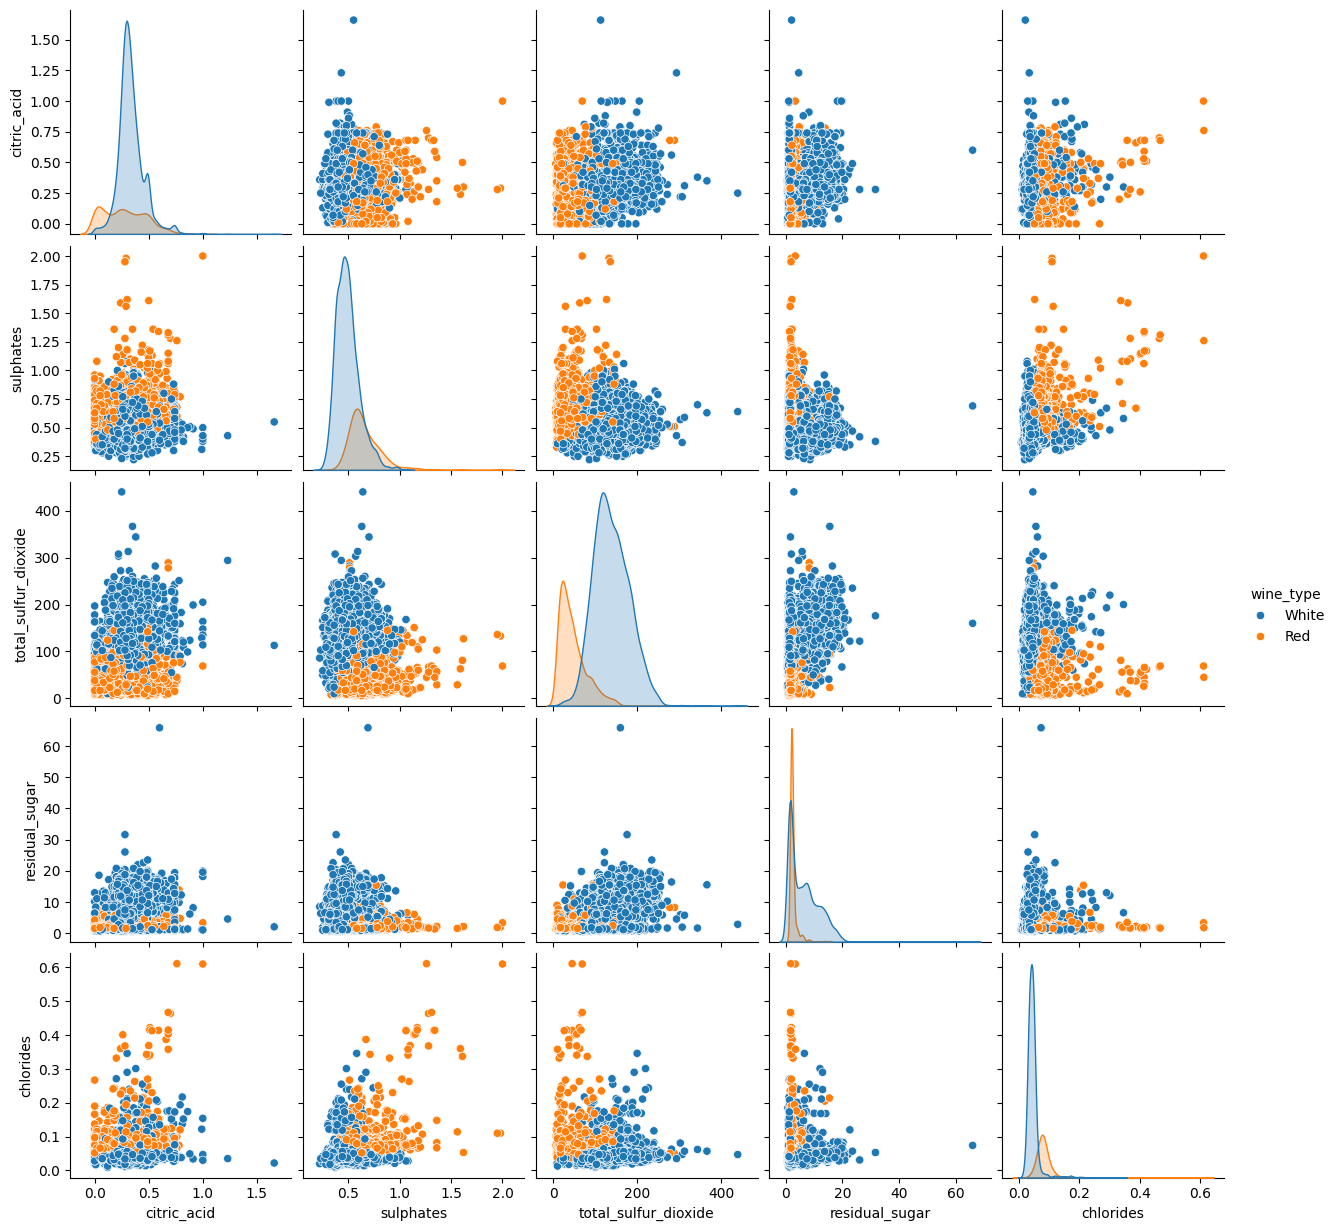

In [23]:
import seaborn as sns

sns.pairplot(data, vars=['citric_acid', 'sulphates','total_sulfur_dioxide','residual_sugar', 'chlorides'], hue='wine_type')

Yo diria que no, porque viendo las graficas de cada clase, la grafica de vino blanco esta dentro de la de vino tinto, es decir toma sus valores en el mismo rango, aunque hay que decir que el vino blanco parece tener un "pico" mas grande.

Eligiria las columnas 'total_sulfur_dioxide' y la columna 'chlorides', que son las que parecen diferir mas en los valores que toman para cada clase, entonces al estar mas alejadas, un clasificador por ejemplo bayesiano podria distingir mas ya que le asignaria mas probabilidad a la clase correspondiente, ya que estan bien separadas.

[0.25346226 0.22082117 0.13679223 0.0890521  0.07004171 0.05503326
 0.04698554 0.04299857 0.03819769 0.02491774]
[0.25346226 0.47428343 0.61107566 0.70012777 0.77016947 0.82520274
 0.87218827 0.91518684 0.95338453 0.97830228 0.9972679  1.        ]


<Axes: >

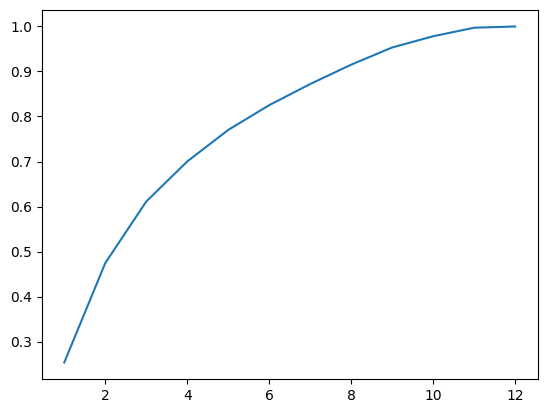

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(x_scaled)

explained_variance = pca.explained_variance_ratio_

print(explained_variance[:10])

acum = np.cumsum(explained_variance)
#Suma acumulativa de las varianzas
print(acum)

sns.lineplot(x=[i for i in range(1, len(acum)+1)], y=acum)


Vemos que ya la sexta componente nos explica aproximadamente un 80% de la varianza acumulada, por lo que deberia usar las primeras 6.

In [37]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

x_pca_white = x_pca[y=='White']
x_pca_red = x_pca[y=='Red']

print(x_pca_red)
print(len(x_pca_red))
print(len(x_pca_white))

[[-2.29653771 -0.52600553]
 [-0.6257931  -0.60245272]
 [-2.31668999  0.14905711]
 ...
 [-3.65111713 -1.22018108]
 [-1.78323067  0.65716413]
 [-3.40550597 -0.68945143]]
1599
4898


In [48]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

model_todas_cols = GaussianNB()
#Asumo que sobre las columnas no estandarizadas si pasadas por pca, que es la division que hice al principio.
model_todas_cols.fit(x_train, y_train)

y_pred = model_todas_cols.predict(x_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         Red       0.94      0.97      0.96       400
       White       0.99      0.98      0.99      1225

    accuracy                           0.98      1625
   macro avg       0.97      0.98      0.97      1625
weighted avg       0.98      0.98      0.98      1625



array([[ 389,   11],
       [  23, 1202]])

In [50]:
#hago la division de datos normalizados y con pca de 6 componentes principales

pca = PCA(n_components=6)

x_pca = pca.fit_transform(x_scaled)

x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(x_pca, y, test_size=0.25, stratify=y, random_state=42)

model_pca = GaussianNB()

model_pca.fit(x_train_pca, y_train_pca)

y_pred_pca = model_pca.predict(x_test_pca)

print(classification_report(y_test_pca, y_pred_pca))
confusion_matrix(y_test_pca, y_pred_pca)

              precision    recall  f1-score   support

         Red       0.97      0.96      0.96       400
       White       0.99      0.99      0.99      1225

    accuracy                           0.98      1625
   macro avg       0.98      0.98      0.98      1625
weighted avg       0.98      0.98      0.98      1625



array([[ 384,   16],
       [  12, 1213]])

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

y_pred_lda = lda.predict(x_test)

print(classification_report(y_test, y_pred_lda))
confusion_matrix(y_test, y_pred_lda)


              precision    recall  f1-score   support

         Red       0.99      0.98      0.99       400
       White       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



array([[ 394,    6],
       [   4, 1221]])

In [52]:
qda = LinearDiscriminantAnalysis()
qda.fit(x_train, y_train)

y_pred_qda = qda.predict(x_test)

print(classification_report(y_test, y_pred_qda))
confusion_matrix(y_test, y_pred_qda)

              precision    recall  f1-score   support

         Red       0.99      0.98      0.99       400
       White       1.00      1.00      1.00      1225

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



array([[ 394,    6],
       [   4, 1221]])

Naive Bayes asume independencia entre caracteristicas y distribucion gaussiana.

LDA asume distribucion gaussiana en sus caracteristicas, y que las clases tienen la misma matriz de varianza covarianza.

QDA tambien asume distribucion gaussiana en sus caracteristicas.

Lo mas razonable me parece que es usar QDA, ya que (fuera de haber visto que tiene el mejor desempeño de entre todos los clasificadores), es el "mas flexible" de los tres en cuanto a hipotesis, claro esta que en realidad tampoco sé la distribucion de los datos del dataset, pero los tres clasificadores asumen distribucion gaussiana.